### Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# install local geoopt first: !pip install -e data/geoopt
import geoopt

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import spearmanr
import matplotlib.patheffects as PathEffects

import _utils
from _utils import set_all_seeds, set_plt_layout
from _utils import calculate_reconstruction_metrics_hmtDNA, calculate_correlation_metrics_hmtDNA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

_utils.reset_plt_layout()
set_all_seeds(0); set_plt_layout()

In [3]:
df = pd.read_pickle("data/hmtDNA/rcrs.pkl", compression='gzip')
df

,SampleID,Haplogroup,Rank,Quality,Range,Not_Found_Polys,Found_Polys,Remaining_Polys,AAC_In_Remainings,Input_Sample,main_geo_loc,sub_geo_loc,latitude,longitude,distance_to_sudan
0,AB055387.1,B5b1a2,1,0.9477,1-16569,960.1C 14766T,73G 103A 199C 204C 263G 709A 750G 1438G 1598A ...,311d (globalPrivateMutation) 523d (hotspot) 52...,NaN,"[73G, 103A, 199C, 204C, 263G, 311d, 523d, 524d...",NaN,NaN,NaN,NaN,NaN
1,AB626609.1,X2e2b,1,0.9616,1-16569,NaN,73G 153G 195C 225A! 263G 750G 1438G 1719A 2706...,309.1C (hotspot) 315.1C (hotspot) 524.1AC (hot...,NaN,"[73G, 153G, 195C, 263G, 309.1C, 315.1C, 524.1A...",NaN,NaN,NaN,NaN,NaN
2,AB626610.1,H3u1,1,0.9652,1-16569,NaN,263G 750G 1438G 4769G 5899.XC 6776C 8860G 9966...,315.1C (hotspot) 3107d (hotspot) 13260C (local...,NaN,"[263G, 315.1C, 750G, 1438G, 3107d, 4769G, 5899...",NaN,NaN,NaN,NaN,NaN
3,AF346963.1,S1,1,0.8481,1-16569,NaN,73G 263G 750G 1438G 2706G 4769G 7028T 8404C 88...,150T (localPrivateMutation) 152C (localPrivate...,12358G [T8A| Codon 1 | ND5 ] 13594G [S420G| Co...,"[73G, 150T, 152C, 252C, 263G, 315.1C, 709A, 75...",Australia,NaN,-24.776109,134.755000,11927.501388
4,AF346964.1,S2,1,0.8058,1-16569,NaN,73G 263G 750G 1438G 2380T 2706G 3438A 4769G 61...,309.1C (hotspot) 315.1C (hotspot) 471C (localP...,13135A [A267T| Codon 1 | ND5 ] 13708A [A458T| ...,"[73G, 263G, 309.1C, 315.1C, 471C, 524.1ACAC, 7...",Australia,NaN,-24.776109,134.755000,11927.501388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63773,PQ468427.1,HV6a,1,1.0000,1-16569,NaN,263G 750G 1438G 2706G 3507T 4769G 6755A 7028T ...,309.1C (hotspot) 315.1C (hotspot) 3107d (hotspot),NaN,"[263G, 309.1C, 315.1C, 750G, 1438G, 2706G, 310...",Poland,NaN,52.215933,19.134422,4251.500278
63774,PQ468428.1,H7a1,1,0.9302,1-16569,NaN,263G 750G 1438G 1719A 4769G 4793G 8860G 15326G...,315.1C (hotspot) 1243C (localPrivateMutation) ...,NaN,"[263G, 315.1C, 750G, 1243C, 1438G, 1719A, 3107...",Poland,NaN,52.215933,19.134422,4251.500278
63775,PQ468429.1,H1c+152,1,0.8940,1-16569,NaN,152C 263G 477C 750G 1438G 3010A 4769G 8860G 15...,146C (localPrivateMutation) 315.1C (hotspot) 3...,NaN,"[146C, 152C, 263G, 315.1C, 326G, 477C, 750G, 1...",Poland,NaN,52.215933,19.134422,4251.500278
63776,V00662.1,M31a2*,1,0.5302,1-16569,73G 150T 195C 263G 489C 750G 868T 1438G 2156.1...,11335T 14766T 16093C!,3107C (globalPrivateMutation) 3423G (globalPri...,9559G [P118R| Codon 2 | COX3 ] 11447C [V230L| ...,"[3107C, 3423G, 4985G, 9559G, 11335T, 11447C, 1...",NaN,NaN,NaN,NaN,NaN


In [4]:
thr = 0.9
print(set(df[df['Quality'] < thr]["Haplogroup"]) - set(df[df['Quality'] >= thr]["Haplogroup"]))

df = df[df['Quality'] >= thr]
df.shape

{'H60', 'M69', 'L1c1', 'M17c1', 'R9b', 'L2a5', "L3c'd", 'M21b1', 'G2a1f', "M34'57", 'M34a', "M1'20'51", "L1c1'2'4'5'6", 'U8b1a2+16311', 'M9', 'D4g2a', "R11'B6", 'M2', "U6a'b'd", 'M28b', 'F2b', 'L4a', 'M4"67+16311', 'H2a2a1', 'X2m', "U5a'b", 'H1e+16129', 'L3h1b', 'M42b2', 'U2b', 'M37+152', 'L4b1', 'M50', 'M52a1', 'U8b1a2a', 'R5a1', 'R30a1*', 'K1+16362', 'HV12a', 'R22', 'B6', 'H30', "M32'56", 'R8', 'L3a2', 'HV14', 'H54', 'H5a1c2', 'H+13708', 'O1', 'B5a2', 'HV20', 'U2c', 'U6a7b', 'U5b2b1a', "U2c'd", 'U6a', 'R+16189', 'I1b*1', 'L4b2a', 'N5', 'B5a2a2b2', 'G', "L2a1'2'3'4", 'L3h1b1', 'M49', 'Q1f', 'M33+16362', 'L3k', 'H13b', 'J1b1a', 'P3b', 'P3b1', 'A', 'B4', 'R6a', 'A11+16234', 'F3a', 'T2d1', "M2a'b", 'L1c3', 'M60', 'H2a4', 'K1b1b', 'R8a', 'H41', 'M50a', 'M13', 'M*1', "L2b'c'd", 'U6a7c', 'H78', 'B4a1c', 'R5a', 'H5v', 'M66', 'H6', 'L3i1', 'H26b', "L2'3'4'5'6", 'M46', 'R0', "L1c1'2'4'6", 'R6+16129*', 'B4d3', 'M4"67', 'M52b', 'K2c', 'K1a7', 'S1', 'M5b2b1', 'M21b1a', 'L3x1', 'H49b', 'F3b', 'H3b

(57385, 15)

In [5]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
one_hot = pd.DataFrame(mlb.fit_transform(df['Input_Sample'].values),
                       columns=mlb.classes_,
                       index=df.index)


# Calculate the frequency of each mutation
mutation_counts = one_hot.sum(axis=0)
total_samples = one_hot.shape[0]
mutation_frequencies = mutation_counts / total_samples

# Display mutation frequencies
print("\nMutation Frequencies:")
print(mutation_frequencies.head())

frequency_threshold = 0.0005
filtered_mutations = mutation_frequencies[mutation_frequencies >= frequency_threshold].index
one_hot_filtered = one_hot[filtered_mutations]
# (61665, 6298)

# Display the filtered one-hot encoded DataFrame
print(f"\nFiltered One-Hot Encoded DataFrame (Mutations with ≥ {frequency_threshold*100}% Frequency):")
print(one_hot_filtered.shape)



Mutation Frequencies:
10000A    0.000017
10000N    0.000802
10001N    0.000802
10002N    0.000732
10003C    0.000139
dtype: float64

Filtered One-Hot Encoded DataFrame (Mutations with ≥ 0.05% Frequency):
(57385, 5366)


In [6]:
df['n_mutations'] = df['Input_Sample'].apply(len)
df['n_kept_mutations'] = one_hot_filtered.sum(axis=1)
df['kept_ratio'] = df['n_kept_mutations'] / df['n_mutations'] 

print(one_hot_filtered.shape)
df[['n_mutations', 'n_kept_mutations']].describe()

# optionally only keep samples where ratio is above 0.5
# df = df[df['kept_ratio'] > 0.9]

/tmp/ipykernel_1358559/219720428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_mutations'] = df['Input_Sample'].apply(len)


(57385, 5366)


/tmp/ipykernel_1358559/219720428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_kept_mutations'] = one_hot_filtered.sum(axis=1)
/tmp/ipykernel_1358559/219720428.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['kept_ratio'] = df['n_kept_mutations'] / df['n_mutations']


,n_mutations,n_kept_mutations
count,57385.000000,57385.000000
mean,42.082478,38.531184
std,73.136099,35.100911
min,1.000000,1.000000
25%,30.000000,30.000000
50%,38.000000,37.000000
75%,44.000000,43.000000
max,4422.000000,1437.000000


In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET

tree = ET.parse('trees/phylotree-fu-rcrs/1.2/tree.xml')
root = tree.getroot()

haplogroup_levels = {}

def traverse(node, level):
    haplogroup_name = node.get('name')
    if haplogroup_name:
        haplogroup_levels[haplogroup_name] = level
    for child in node.findall('haplogroup'):
        traverse(child, level + 1)

traverse(root, 0)
# haplogroup_levels.pop('mtMRCA', None)
haplogroup_levels = {k: v - 1 for k, v in haplogroup_levels.items()}

df['level'] = df['Haplogroup'].map(haplogroup_levels)
assert df['level'].isna().sum() == 0
df['level'] = df['level'].astype(int)

print(haplogroup_levels, df['level'].value_counts())


In [8]:
class Nodes(torch.utils.data.Dataset):
    def __init__(self, dataset, subset=None, level=None, haplogroup=None, obs=None):
        super(Nodes, self).__init__()
        self.data = dataset[subset] if subset is not None else dataset
        if level is not None: self.level = level[subset] if subset is not None else level
        if haplogroup is not None: self.haplogroup = haplogroup[subset] if subset is not None else haplogroup
        if obs is not None: self.obs = obs.iloc[subset] if subset is not None else obs

        self.data = torch.tensor(self.data, dtype=torch.float64)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return index, self.data[index], index

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

data = torch.tensor(one_hot_filtered.loc[df.index.tolist()].values, dtype=torch.float64)

In [9]:
set_all_seeds(0)

# Split data into train, validation and test sets (82/9/9)
indices = np.arange(len(data))
np.random.shuffle(indices)

train_size = int(0.82 * len(indices))
val_size = int(0.09 * len(indices))
test_size = len(indices) - train_size - val_size

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_data = Nodes(data, train_indices, level=df['level'].values, haplogroup=df['Haplogroup'].values, obs=df)
val_data = Nodes(data, val_indices, level=df['level'].values, haplogroup=df['Haplogroup'].values, obs=df)
test_data = Nodes(data, test_indices, level=df['level'].values, haplogroup=df['Haplogroup'].values, obs=df)

batch_size = 2048
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


/tmp/ipykernel_1358559/2894625206.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data, dtype=torch.float64)


### Model definition

In [10]:
# ---------------------------------
# - Riemannian generative decoder - 
# ---------------------------------

class RGD(nn.Module):
    def __init__(self, dim_list, manifold=geoopt.manifolds.Euclidean(), output_activation=None):
        super(RGD, self).__init__()
        self.dim_list = dim_list 
        self.manifold = manifold 
        self.origin = self.manifold.origin(dim_list[0], seed=None, device=device)
        
        # fc decoder stack with swish activations 
        layers = []
        for i in range(len(dim_list) - 1):
            layers.append(nn.Linear(dim_list[i], dim_list[i + 1]))
            if i != len(dim_list) - 2: # only activations for hidden layers
                layers.append(nn.SiLU())
                
        if output_activation is not None:
            layers.append(output_activation)

        self.decoder = nn.Sequential(*layers)

    def forward(self, z):
        return self.decoder(z)

    def init_samples(self, n):
        # manifold-projected points with small noise opposite origin 
        z = 1e-3 * torch.randn(n, self.dim_list[0], device=device) - self.origin 
        z = self.manifold.projx(z)
        return geoopt.ManifoldParameter(z, manifold=self.manifold, requires_grad=True)
    
from _train import train_rgd
torch.set_default_dtype(torch.float64)  # Set default tensor type

In [ ]:
# define parameters 
device = "cuda:0"
dim_list = [3, 16, 32, 64, 128, 256, train_data.data.shape[1]]

c = 5; std = 0.5
manifold = geoopt.manifolds.Lorentz(k=c)
# manifold = geoopt.manifolds.Euclidean(1); use_prior = True

# initialize and train model
model = RGD(dim_list, manifold)
model.z = model.init_samples(len(train_data))
model.z_val = model.init_samples(len(val_data))
train_rgd(model, F.binary_cross_entropy_with_logits, train_loader, val_loader, [1e-1, 2e-3], betas=(0.9, 0.995), 
    n_epochs=1000, device=device, patience=85, start_saving=150, wd=1e-3, noise_std=std, use_prior=False)

# find test-time representations 
loss_fn = lambda x, y: F.binary_cross_entropy_with_logits(x, y, reduction='none')
ztest = _utils.get_representations(model, test_loader, loss_fn, n_start_points_per_sample=15, n_epochs=600, lr=8e-2, betas=(0.5, 0.7), wd=0, device=device)
model.z_test = ztest

### Evaluation

In [12]:
# Compute results 
pearson, spearman = calculate_correlation_metrics_hmtDNA(model.z, manifold, train_data)
test_pearson, test_spearman = calculate_correlation_metrics_hmtDNA(model.z_test, manifold, test_data)
train_bce, train_f1 = calculate_reconstruction_metrics_hmtDNA(model, model.z, train_data)
test_bce, test_f1 = calculate_reconstruction_metrics_hmtDNA(model, model.z_test, test_data)
print(f"Train: Pearson={round(pearson, 3)}, Spearman={round(spearman, 3)}, BCE={round(train_bce, 3)}, F1={round(train_f1, 3)}")
print(f" Test: Pearson={round(test_pearson, 3)}, Spearman={round(test_spearman, 3)}, BCE={round(test_bce, 3)}, F1={round(test_f1, 3)}")

Train: Pearson=0.283, Spearman=0.501, BCE=0.01, F1=0.787
 Test: Pearson=0.17, Spearman=0.33, BCE=0.009, F1=0.812


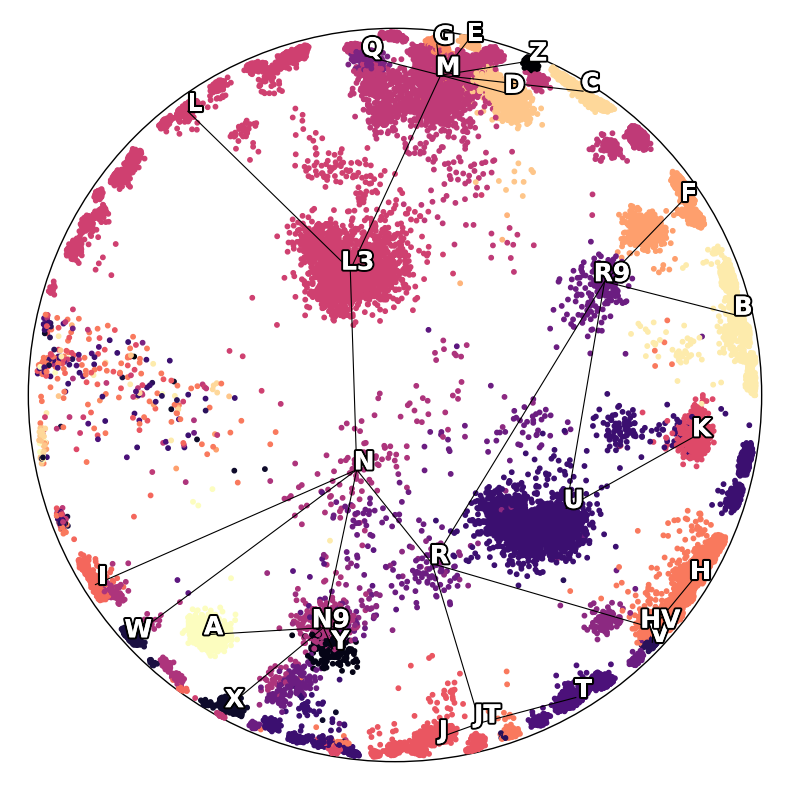

In [13]:
disk_radius = 1

def lorentz_to_poincare(z, k=c):
    return z[:, 1:] / (z[:, :1])

kept = (train_data.obs["n_kept_mutations"] / train_data.obs["n_mutations"] >= 0.5).values
z = model.z[kept]
obs = train_data.obs[kept]
z_p = lorentz_to_poincare(z)
z_p = z_p.data.cpu().numpy()

two_letter = obs.Haplogroup.str[:2]
cats2 = two_letter.astype('category')
codes2 = cats2.cat.codes.values
labels2 = cats2.cat.categories

one_letter = obs.Haplogroup.str[:1]
cats1 = one_letter.astype('category')
codes1 = cats1.cat.codes.values
labels1 = cats1.cat.categories

edges = [
    ('L','L3'),
    ('L3','M'),('L3','N'),
    ('N','R'),
    ('M','E'),('M','D'),('M','C'),('M','Z'),('M','G'),('M', 'Q'),
    ('R','HV'),('R','JT'),
    ('R', 'R9'), ('R9', 'U'), ('U', 'K'), ('R9', 'B'), ('R9', 'F'),
    ('N','W'),('N','I'), ('N', 'N9'),
    ('N9','Y'),('N9','A'),('N9','X'),
    ('HV','H'),('HV','V'),
    ('JT','J'),('JT','T'),
]

nodes = {n for e in edges for n in e}
medians = {}
for lbl in nodes:
    if lbl == 'L':
        mask = obs.Haplogroup.str.startswith('L') & ~obs.Haplogroup.str.startswith('L3')
    elif lbl == 'N':
        mask = obs.Haplogroup.str.startswith('N2') 
    elif lbl == 'L3':
        mask = obs.Haplogroup.str.startswith('L3')
    elif lbl == 'HV':
        mask = obs.Haplogroup.str.startswith('HV') 
    elif lbl == 'JT':
        mask = obs.Haplogroup.str.startswith('J') | obs.Haplogroup.str.startswith('T')
    elif lbl == 'R':
        mask = obs.Haplogroup.str.startswith('R2') 
    elif lbl == 'R9':
        mask = obs.Haplogroup.str.startswith('R9')
    elif lbl == 'U':
        mask = obs.Haplogroup.str.startswith('U')
    elif lbl == 'N9':
        mask = obs.Haplogroup.str.startswith('N9')
    else:
        mask = obs.Haplogroup.str[:1] == lbl
    if mask.any():
        medians[lbl] = (
            np.median(z_p[mask,0]),
            np.median(z_p[mask,1])
        )

fig, ax = plt.subplots(figsize=(8,8))
ax.add_artist(plt.Circle((0,0), disk_radius, fill=False, color='black'))
# ax.scatter(z_p[:,0], z_p[:,1], c=obs['level'], s=10, cmap='magma')
ax.scatter(z_p[:,0], z_p[:,1], c=codes1, s=10, cmap='magma_r')


for parent, child in edges:
    p = medians[parent]
    c = medians[child]
    ax.plot([p[0], c[0]], [p[1], c[1]], 'k-', linewidth=0.8)

for lbl, (x,y) in medians.items():
    disp = lbl if lbl in ('L3','JT','HV','N9','R9') else lbl[0]
    txt = ax.annotate(disp, (x+0.02,y+0.02), fontsize=18, fontweight='bold',
                      ha='center', va='center', color='white')
    txt.set_path_effects([
        PathEffects.withStroke(linewidth=3, foreground='black'),
        PathEffects.Normal()
    ])

ax.set_xlim(-1.05,1.05)
ax.set_ylim(-1.05,1.05)
ax.set_aspect('equal', 'box')
plt.tight_layout()
# plt.savefig(f'results/pdfs/final_hmtdna_rcrs{std:.1f}std.pdf', dpi=300, bbox_inches='tight')
# plt.savefig(f'results/pngs/final_hmtdna_rcrs{std:.1f}std.png', dpi=300, bbox_inches='tight')
plt.show()

### Further statistics and plotting

In [ ]:
from copy import deepcopy
from geoopt import manifolds
from _utils import set_all_seeds, get_representations

N_REPS = 3

loss_fn = lambda x, y: F.binary_cross_entropy_with_logits(x, y, reduction='none')
configs = [
    ("Lorentz 0.1std 5c", manifolds.Lorentz(k=5), 0.1),
    ("Lorentz 0.5std 5c", manifolds.Lorentz(k=5), 0.5),
    ("Euclidean(2)", manifolds.Euclidean(1), 0),
]
results = {}
for name, manifold, std in configs:
    print(name)
    pearsons_train, spearmans_train, bces_train, f1s_train = [], [], [], []
    pearsons_test, spearmans_test, bces_test, f1s_test = [], [], [], []
    
    for rep in range(N_REPS):  
        set_all_seeds(rep)
        dim_list = [3, 16, 32, 64, 128, 256, train_data.data.shape[1]] 
        use_prior = False
        if name == "Euclidean(2)": 
            dim_list[0] = 2
            use_prior = True
        model = RGD(dim_list, manifold)
        model.z = model.init_samples(len(train_data))
        model.z_val = model.init_samples(len(val_data))
        train_rgd(model, F.binary_cross_entropy_with_logits, train_loader, val_loader, 
            [1e-1, 2e-3], betas=(0.9, 0.995), n_epochs=1000, device=device, beta=100, use_prior=use_prior,
            patience=85, start_saving=150, wd=1e-3, noise_std=std)

        # Train metrics
        ztrain = model.z.detach()
        p_train, s_train = calculate_correlation_metrics_hmtDNA(ztrain, manifold, train_data)
        m1_train, m2_train = calculate_reconstruction_metrics_hmtDNA(model, ztrain, train_data)
        pearsons_train.append(p_train)
        spearmans_train.append(s_train)
        bces_train.append(m1_train)
        f1s_train.append(m2_train)

        # Test metrics
        ztest = get_representations(model, test_loader, loss_fn, n_start_points_per_sample=15, n_epochs=600, lr=8e-2, betas=(0.5, 0.7), wd=0, device=device)
        model.z_test = ztest
        p_test, s_test = calculate_correlation_metrics_hmtDNA(ztest, manifold, test_data)
        m1_test, m2_test = calculate_reconstruction_metrics_hmtDNA(model, ztest, test_data)
        pearsons_test.append(p_test)
        spearmans_test.append(s_test)
        bces_test.append(m1_test)
        f1s_test.append(m2_test)

        if rep == 0:
            # save the model
            if name == "Lorentz 0.1std 5c":
                lorentz01 = deepcopy(model)
            elif name == "Euclidean(2)":
                euclidean = deepcopy(model)
        if rep == 1:
            if name == "Lorentz 0.5std 5c":
                lorentz05 = deepcopy(model)
        
    results[name] = {
        'train': {
            'pearson_mean': np.mean(pearsons_train), 'pearson_std': np.std(pearsons_train),
            'spearman_mean': np.mean(spearmans_train), 'spearman_std': np.std(spearmans_train),
            'bce_mean': np.mean(bces_train), 'bce_std': np.std(bces_train),
            'F1_mean': np.mean(f1s_train), 'F1_std': np.std(f1s_train)
        },
        'test': {
            'pearson_mean': np.mean(pearsons_test), 'pearson_std': np.std(pearsons_test),
            'spearman_mean': np.mean(spearmans_test), 'spearman_std': np.std(spearmans_test), 
            'bce_mean': np.mean(bces_test), 'bce_std': np.std(bces_test),
            'F1_mean': np.mean(f1s_test), 'F1_std': np.std(f1s_test)
        }
    }
print(results)

In [15]:
# Build a DataFrame `df` with results
idx = []
data = {}
for name, vals in results.items():
    idx.append(name)
    for split, split_name in [('train', 'Train'), ('test', 'Test')]:
        for metric, metric_name in [
            ('pearson', 'Pearson'),
            ('spearman', 'Spearman'),
            ('bce', 'BCE'),
            ('F1', 'F1')
        ]:
            m = vals[split][f'{metric}_mean']
            s = vals[split][f'{metric}_std']
            # entry = f"{m:.2f}\\raisebox{{0.ex}}{{\\scriptsize $\\pm${s:.2f}}}"
            entry = f"{m:.2f}{{\\scriptsize $\\pm${s:.2f}}}"
            data.setdefault((split_name, metric_name), []).append(entry)

df = pd.DataFrame(data, index=idx)
df.index.name = 'Manifold'
cols = [(g, m) for g in ['Train', 'Test'] for m in ['Pearson', 'Spearman', 'BCE', 'F1']]
df = df[cols]

name_map = {
    "Lorentz 0.1std 5c": r"rCRS $\mathbb{H}^2$ {\scriptsize($\sigma=0.1$)}",
    "Lorentz 0.5std 5c": r"rCRS $\mathbb{H}^2$ {\scriptsize($\sigma=0.5$)}",
    "Euclidean(2)":      r"rCRS $\mathbb{R}^2$ {\scriptsize($\sigma=0.0$)}",
}

# Print LaTeX table manually
print(r"\begin{table}")
print(r"\caption{\textbf{Correlation and reconstruction metrics across three runs for the hmtDNA dataset (formatted as mean $\pm$ std).}}\vspace{4px}")
print(r"\label{tab:rcrs}")
print(r"\resizebox{\textwidth}{!}{%")
print(r"\begin{tabular}{c|cccc|cccc}")
print(r"\multicolumn{1}{l}{} & \multicolumn{4}{c}{\textbf{Train}} & \multicolumn{4}{c}{\textbf{Test}} \\")
print(r"& Pearson & Spearman & BCE & F1 & Pearson & Spearman & BCE & F1 \\")
print(r"\midrule")
for name in df.index:
    label = name_map.get(name, name)
    entries = [
        df.loc[name, ('Train','Pearson')],
        df.loc[name, ('Train','Spearman')],
        df.loc[name, ('Train','BCE')],
        df.loc[name, ('Train','F1')],
        df.loc[name, ('Test','Pearson')],
        df.loc[name, ('Test','Spearman')],
        df.loc[name, ('Test','BCE')],
        df.loc[name, ('Test','F1')],
    ]
    print(f"{label} & " + " & ".join(entries) + r" \\")
print(r"\end{tabular}")
print(r"}")
print(r"\end{table}")

\begin{table}
\caption{\textbf{Correlation and reconstruction metrics across three runs for the hmtDNA dataset (formatted as mean $\pm$ std).}}\vspace{4px}
\label{tab:rcrs}
\resizebox{\textwidth}{!}{%
\begin{tabular}{c|cccc|cccc}
\multicolumn{1}{l}{} & \multicolumn{4}{c}{\textbf{Train}} & \multicolumn{4}{c}{\textbf{Test}} \\
& Pearson & Spearman & BCE & F1 & Pearson & Spearman & BCE & F1 \\
\midrule
rCRS $\mathbb{H}^2$ {\scriptsize($\sigma=0.1$)} & 0.18{\scriptsize $\pm$0.02} & 0.17{\scriptsize $\pm$0.05} & 0.01{\scriptsize $\pm$0.00} & 0.88{\scriptsize $\pm$0.00} & -0.00{\scriptsize $\pm$0.08} & -0.04{\scriptsize $\pm$0.13} & 0.02{\scriptsize $\pm$0.00} & 0.74{\scriptsize $\pm$0.01} \\
rCRS $\mathbb{H}^2$ {\scriptsize($\sigma=0.5$)} & 0.28{\scriptsize $\pm$0.01} & 0.46{\scriptsize $\pm$0.04} & 0.01{\scriptsize $\pm$0.00} & 0.78{\scriptsize $\pm$0.01} & 0.15{\scriptsize $\pm$0.01} & 0.28{\scriptsize $\pm$0.03} & 0.01{\scriptsize $\pm$0.00} & 0.80{\scriptsize $\pm$0.01} \\
rCRS $\mathbb

In [16]:
# Define region mapping based on haplogroup first character
def map_region(haplogroup):
    if not isinstance(haplogroup, str) or len(haplogroup) == 0:
        return 'Other'
    first_char = haplogroup[0].upper()
    if first_char == 'L':
        return 'Africa'
    elif first_char in ['F', 'B', 'P', 'A', 'S', 'O', 'Y', 'N', 'M', 'Q', 'G', 'E', 'D', 'C', 'Z']:
        return 'Asia'
    elif first_char in ['H', 'V', 'U', 'K', 'J', 'T', 'R', 'W', 'X', 'I']:
        return 'Europe'
    else:
        return 'Other'

train_data.obs['Region'] = train_data.obs['Haplogroup'].apply(map_region)
train_data.obs['Region'].value_counts()
hap = train_data.obs.Haplogroup.str[:2].astype('category').cat.codes
muts = (train_data.obs["n_kept_mutations"]  / train_data.obs["n_mutations"]).values


/tmp/ipykernel_1358559/2986268697.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.obs['Region'] = train_data.obs['Haplogroup'].apply(map_region)


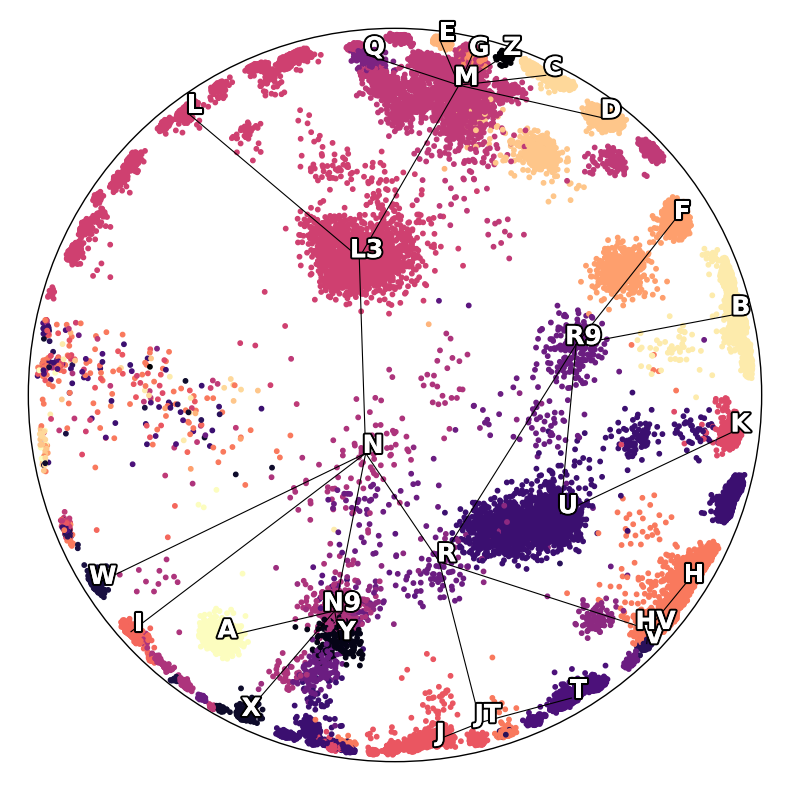

In [17]:
kept = (train_data.obs["n_kept_mutations"] / train_data.obs["n_mutations"] >= 0.5).values
z = lorentz05.z[kept]
obs = train_data.obs[kept]
z_p = lorentz_to_poincare(z) if manifold.name=='Lorentz' else z
z_p = z_p.data.cpu().numpy()

two_letter = obs.Haplogroup.str[:2]
cats2 = two_letter.astype('category')
codes2 = cats2.cat.codes.values
labels2 = cats2.cat.categories

one_letter = obs.Haplogroup.str[:1]
cats1 = one_letter.astype('category')
codes1 = cats1.cat.codes.values
labels1 = cats1.cat.categories

edges = [
    ('L','L3'),
    ('L3','M'),('L3','N'),
    ('N','R'),
    ('M','E'),('M','D'),('M','C'),('M','Z'),('M','G'),('M', 'Q'),
    ('R','HV'),('R','JT'),
    ('R', 'R9'), ('R9', 'U'), ('U', 'K'), ('R9', 'B'), ('R9', 'F'),
    ('N','W'),('N','I'), ('N', 'N9'), 
    ('N9','Y'),('N9','A'),('N9','X'),
    ('HV','H'),('HV','V'),
    ('JT','J'),('JT','T'),
]

nodes = {n for e in edges for n in e}
medians = {}
for lbl in nodes:
    if lbl == 'L':
        mask = obs.Haplogroup.str.startswith('L') & ~obs.Haplogroup.str.startswith('L3')
    elif lbl == 'N':
        mask = obs.Haplogroup.str.startswith('N2') 
    elif lbl == 'L3':
        mask = obs.Haplogroup.str.startswith('L3')
    elif lbl == 'HV':
        mask = obs.Haplogroup.str.startswith('HV') 
    elif lbl == 'JT':
        mask = obs.Haplogroup.str.startswith('J') | obs.Haplogroup.str.startswith('T')
    elif lbl == 'R':
        mask = obs.Haplogroup.str.startswith('R2')
    elif lbl == 'R9':
        mask = obs.Haplogroup.str.startswith('R9')
    elif lbl == 'U':
        mask = obs.Haplogroup.str.startswith('U')
    elif lbl == 'N9':
        mask = obs.Haplogroup.str.startswith('N9')
    else:
        mask = obs.Haplogroup.str[:1] == lbl
    if mask.any():
        medians[lbl] = (
            np.median(z_p[mask,0]),
            np.median(z_p[mask,1])
        )

fig, ax = plt.subplots(figsize=(8,8))
ax.add_artist(plt.Circle((0,0), disk_radius, fill=False, color='black'))
ax.scatter(z_p[:,0], z_p[:,1], c=codes1, s=10, cmap='magma_r')


for parent, child in edges:
    p = medians[parent]
    c = medians[child]
    ax.plot([p[0], c[0]], [p[1], c[1]], 'k-', linewidth=0.8)

for lbl, (x,y) in medians.items():
    disp = lbl if lbl in ('L3','JT','HV','N9','R9') else lbl[0]
    txt = ax.annotate(disp, (x+0.02,y+0.02), fontsize=18, fontweight='bold',
                      ha='center', va='center', color='white')
    txt.set_path_effects([
        PathEffects.withStroke(linewidth=3, foreground='black'),
        PathEffects.Normal()
    ])

ax.set_xlim(-1.05,1.05)
ax.set_ylim(-1.05,1.05)
ax.set_aspect('equal', 'box')
plt.tight_layout()
# plt.savefig(f'results/pdfs/final_hmtdna_rcrs{std:.1f}std.pdf', dpi=300, bbox_inches='tight')
# plt.savefig(f'results/pngs/final_hmtdna_rcrs{std:.1f}std.png', dpi=300, bbox_inches='tight')
plt.show()


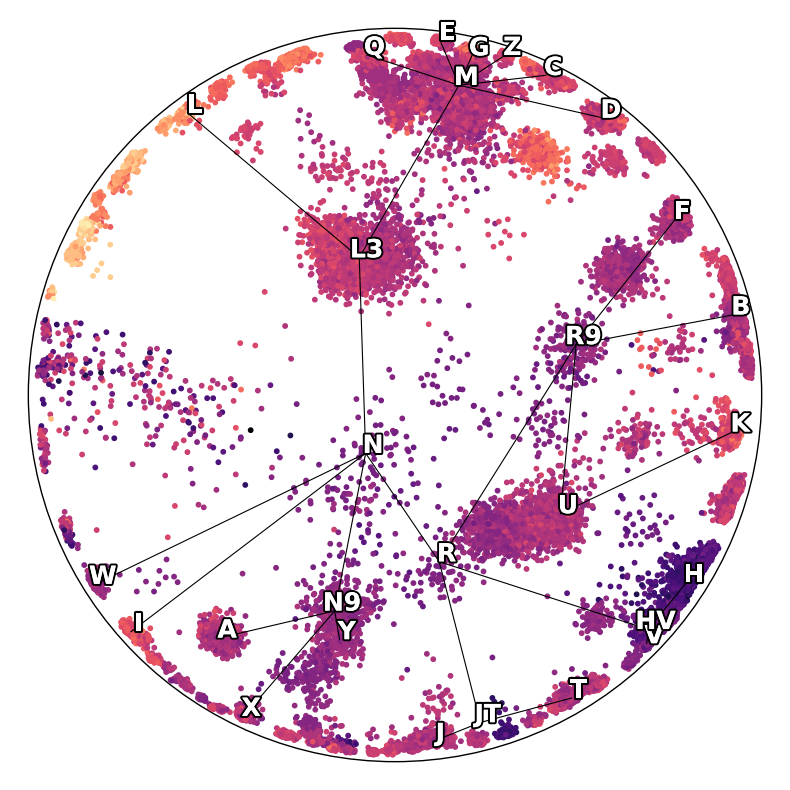

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
ax.add_artist(plt.Circle((0,0), disk_radius, fill=False, color='black'))
ax.scatter(z_p[:,0], z_p[:,1], c=obs['level'], s=10, cmap='magma')

for parent, child in edges:
    p = medians[parent]
    c = medians[child]
    ax.plot([p[0], c[0]], [p[1], c[1]], 'k-', linewidth=0.8)

for lbl, (x,y) in medians.items():
    disp = lbl if lbl in ('L3','JT','HV','N9','R9') else lbl[0]
    txt = ax.annotate(disp, (x+0.02,y+0.02), fontsize=18, fontweight='bold',
                      ha='center', va='center', color='white')
    txt.set_path_effects([
        PathEffects.withStroke(linewidth=3, foreground='black'),
        PathEffects.Normal()
    ])

ax.set_xlim(-1.05,1.05)
ax.set_ylim(-1.05,1.05)
ax.set_aspect('equal', 'box')
plt.tight_layout()
# plt.savefig(f'results/pdfs/final_level_hmtdna_rcrs{std:.1f}std.pdf', dpi=300, bbox_inches='tight')
# plt.savefig(f'results/pngs/final_level_hmtdna_rcrs{std:.1f}std.png', dpi=300, bbox_inches='tight')
plt.show()


### Noise ablation

In [19]:
noise_levels = np.linspace(0, np.sqrt(5), 8) ** 2  # Quadratic spacing
noise_levels = np.round(noise_levels, 1)[:-2]
print("Noise levels (std):", noise_levels)


Noise levels (std): [0.  0.1 0.4 0.9 1.6 2.6]


In [ ]:
# storage
models = {}
metrics = []

for std in noise_levels:
    print(f"\nTraining σ = {std:.4f} …")
    set_all_seeds(0)
    # init & train
    model = RGD(dim_list, manifold)
    model.z     = model.init_samples(len(train_data))
    model.z_val = model.init_samples(len(val_data))
    train_rgd(model, F.binary_cross_entropy_with_logits, train_loader, val_loader, 
        [1e-1, 2e-3], betas=(0.9, 0.995), n_epochs=1000, device=device, beta=100, use_prior=False,
        print_loss_step=5, patience=85, start_saving=150, wd=1e-3, noise_std=std)
    models[std] = model

    # compute train‐set metrics
    zt = model.z.detach()
    _, p = calculate_correlation_metrics_hmtDNA(zt, manifold, train_data)
    _, mse = calculate_reconstruction_metrics_hmtDNA(model, zt, train_data)
    metrics.append((std, p, mse))

# # Save models
# for std, model in models.items():
#     torch.save(model.state_dict(), f'models/mtdna_rcrs_countries_std{std:.1f}.pt')
#     print(f"Saved model with std={std:.1f} at path: models/mtdna_rcrs_countries_std{std:.1f}.pt")

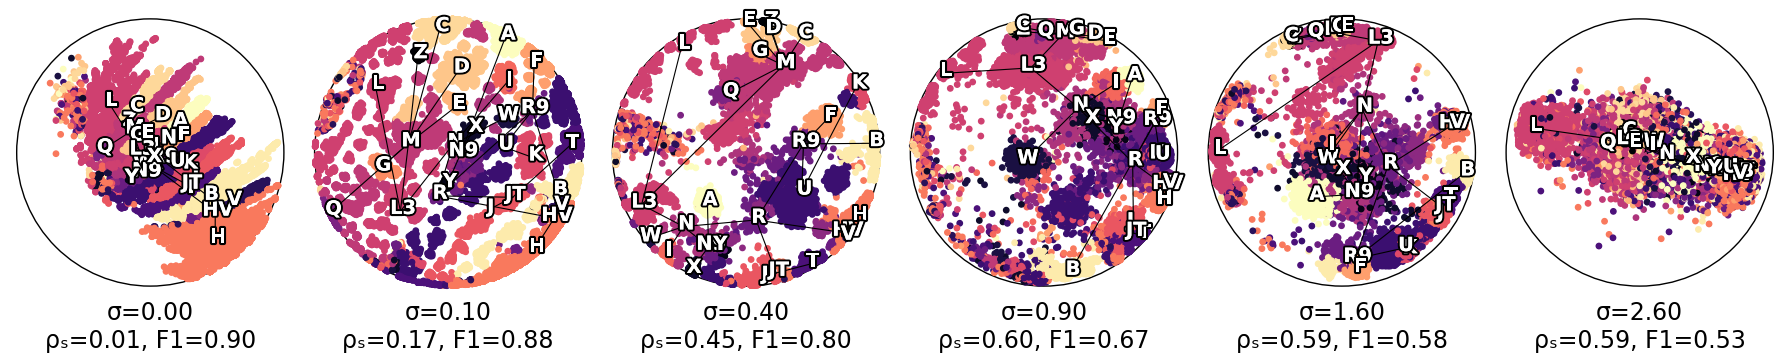

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patheffects as PathEffects

def lorentz_to_poincare(z, k=c):
    return z[:, 1:] / (z[:, :1])

subset = metrics
disk_radius = 1
kept = (train_data.obs["n_kept_mutations"] / train_data.obs["n_mutations"] >= 0.5).values

obs = train_data.obs[kept]

two_letter = obs.Haplogroup.str[:2]
cats2 = two_letter.astype('category')
codes2 = cats2.cat.codes.values
labels2 = cats2.cat.categories

one_letter = obs.Haplogroup.str[:1]
cats1 = one_letter.astype('category')
codes1 = cats1.cat.codes.values
labels1 = cats1.cat.categories

edges = [
    ('L','L3'),
    ('L3','M'),('L3','N'),
    ('N','R'),
    ('M','E'),('M','D'),('M','C'),('M','Z'),('M','G'),('M','Q'),
    ('R','HV'),('R','JT'),
    ('R','R9'), ('R9','U'), ('U','K'), ('R9','B'), ('R9','F'),
    ('N','W'),('N','I'), ('N','N9'),
    ('N9','Y'),('N9','A'),('N9','X'),
    ('HV','H'),('HV','V'),
    ('JT','J'),('JT','T'),
]

fig, axes = plt.subplots(1, len(subset), figsize=(18, 5))
plt.subplots_adjust(wspace=0.02, bottom=0.18)

for ax, (std, pearson, mse) in zip(axes, subset):
    zt = models[std].z.detach()[kept]
    zp = lorentz_to_poincare(zt)

    nodes = {n for e in edges for n in e}
    medians = {}
    for lbl in nodes:
        if lbl == 'L':
            mask = obs.Haplogroup.str.startswith('L') & ~obs.Haplogroup.str.startswith('L3')
        elif lbl == 'N':
            mask = obs.Haplogroup.str.startswith('N2')
        elif lbl == 'L3':
            mask = obs.Haplogroup.str.startswith('L3')
        elif lbl == 'HV':
            mask = obs.Haplogroup.str.startswith('HV')
        elif lbl == 'JT':
            mask = obs.Haplogroup.str.startswith('J') | obs.Haplogroup.str.startswith('T')
        elif lbl == 'R':
            mask = obs.Haplogroup.str.startswith('R2')
        elif lbl == 'R9':
            mask = obs.Haplogroup.str.startswith('R9')
        elif lbl == 'U':
            mask = obs.Haplogroup.str.startswith('U')
        elif lbl == 'N9':
            mask = obs.Haplogroup.str.startswith('N9')
        else:
            mask = obs.Haplogroup.str[:1] == lbl
        if mask.any():
            medians[lbl] = (np.median(zp[mask,0]), np.median(zp[mask,1]))

    ax.add_artist(plt.Circle((0, 0), disk_radius, edgecolor='black', fill=False))
    ax.scatter(zp[:, 0], zp[:, 1], c=codes1, s=15, alpha=1, cmap='magma_r')

    for parent, child in edges:
        p = medians[parent]
        c = medians[child]
        ax.plot([p[0], c[0]], [p[1], c[1]], 'k-', linewidth=0.8)

    for lbl, (x, y) in medians.items():
        disp = lbl if lbl in ('L3','JT','HV','N9','R9') else lbl[0]
        txt = ax.annotate(disp, (x+0.02, y+0.02), fontsize=14, fontweight='bold',
                          ha='center', va='center', color='white')
        txt.set_path_effects([
            PathEffects.withStroke(linewidth=3, foreground='black'),
            PathEffects.Normal()
        ])

    if manifold.name == 'Lorentz':
        ax.set_xlim(-1.05 * disk_radius, 1.05 * disk_radius)
        ax.set_ylim(-1.05 * disk_radius, 1.05 * disk_radius)
    ax.set_aspect('equal')
    ax.set_xticks([]); ax.set_yticks([])

    ax.text(
        0.5, -0.03,
        f"σ={std:.2f}\nρₛ={pearson:.2f}, F1={mse:.2f}",
        transform=ax.transAxes,
        ha='center', va='top',
        fontsize=17
    )

plt.tight_layout()
# plt.savefig('results/pngs/app_hmtdna_ablation_spearman.png', dpi=300, bbox_inches='tight')
# plt.savefig('results/pdfs/app_hmtdna_ablation_spearman.pdf', dpi=300, bbox_inches='tight')
plt.show()
